# Velocity profiles

In [79]:
# Librerías estándar y de terceros
import os
import sys
import gc
import math as m
import numpy as np
import scipy
import pandas as pd
from scipy import *
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import numpy as np
import pylab
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (11, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  # Use 'Comic Sans MS' or 'Helvetica' here as needed
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
}

pylab.rcParams.update(params)
# Configuración de rutas para importaciones personalizadas
#sys.path.append('/projects/DEIKE/cmartinb/jupyter_notebook/project_specific/turbulence')
sys.path.append('/projects/DEIKE/cmartinb/functions')

# Funciones y clases personalizadas
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import *  # Asegúrate de que la importación con * sea necesaria, a veces es mejor importar solo las funciones necesarias

os.chdir('/projects/DEIKE/cmartinb/')

In [80]:
# DEFINE CASE SO WE CAN AUTHOMATIZE IT 
kpHs = '0p08' # 0p16 
uoc = '0p50' # 0p25 0p75

#Common parameters 
kp = 4
u = 0.5
lambdap = 2*m.pi/kp
Re_water = 2.5 * 10**4

In [88]:
def calculate_parameters(kpHs, uoc):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

In [89]:
ak, c, omegap, nu_water, g , uoc_val= calculate_parameters(kpHs, uoc)
print('ak is', ak, 'c is' ,c, 'w_p$ is', omegap, '$\nu_w$ is' , nu_water, 'g is' ,g)

ak is 0.08 c is 1.0 w_p$ is 2.0 $
u_w$ is 6.283185307179586e-05 g is 1


In [90]:
work_dir = f'/projects/DEIKE/nscapin/broadband/kpHs{kpHs}_uoc{uoc}/'
data = np.loadtxt(work_dir+'profiles/log_pro.out')

istep_c =data[:, 1]
time = data[:,0] 

In [91]:
#phi    u.x     u.y     u.z     p       omega   uv      duy     diss    ke      vke     dkdy 

In [ ]:
log_filename = work_dir + 'profiles/log_pro.out'
data_field = np.loadtxt(log_filename)

# Definimos las columnas del DataFrame
columns = ['time', 'istep', 'phi', 'u.x', 'u.y', 'u.z', 'p', 'omega', 'uv', 'duy', 'diss', 'ke', 'vke', 'dkdy']

# Inicializamos una lista vacía para guardar los datos
all_profiles = []

# Loop a través de los índices de los pasos
for idx, row in enumerate(data_field):
    time_step = row[0]
    istep = int(row[1])

    # Leer el archivo de perfil correspondiente
    filename = work_dir + f'profiles/prof_{istep:09}.out'
    profile_data = np.loadtxt(filename)

    # Suponemos que 'profile_data' tiene la forma (M, 14), donde M es el número de mediciones
    # Creamos un diccionario con los datos de este paso de tiempo, cada entrada del diccionario será un vector
    profile_dict = {'time': time_step, 'istep': istep}
    for col_idx, col_name in enumerate(columns[2:]):  # Comenzamos en 2 para saltarnos 'time' y 'istep'
        profile_dict[col_name] = profile_data[:, col_idx].tolist()  # Convertimos a lista para evitar problemas con pandas

    all_profiles.append(profile_dict)

# Convertimos la lista de diccionarios en un DataFrame
profiles_df = pd.DataFrame(all_profiles)

# Guardamos el DataFrame como un archivo CSV
profiles_df.to_csv(f'profiles_kpHs{kpHs}_uoc{uoc}.csv', index=False)


In [ ]:
csv_filename = f'profiles_kpHs{kpHs}_uoc{uoc}.csv'
profiles_df = pd.read_csv(csv_filename)
#print(profiles_df)

### Velocity in all the time interval

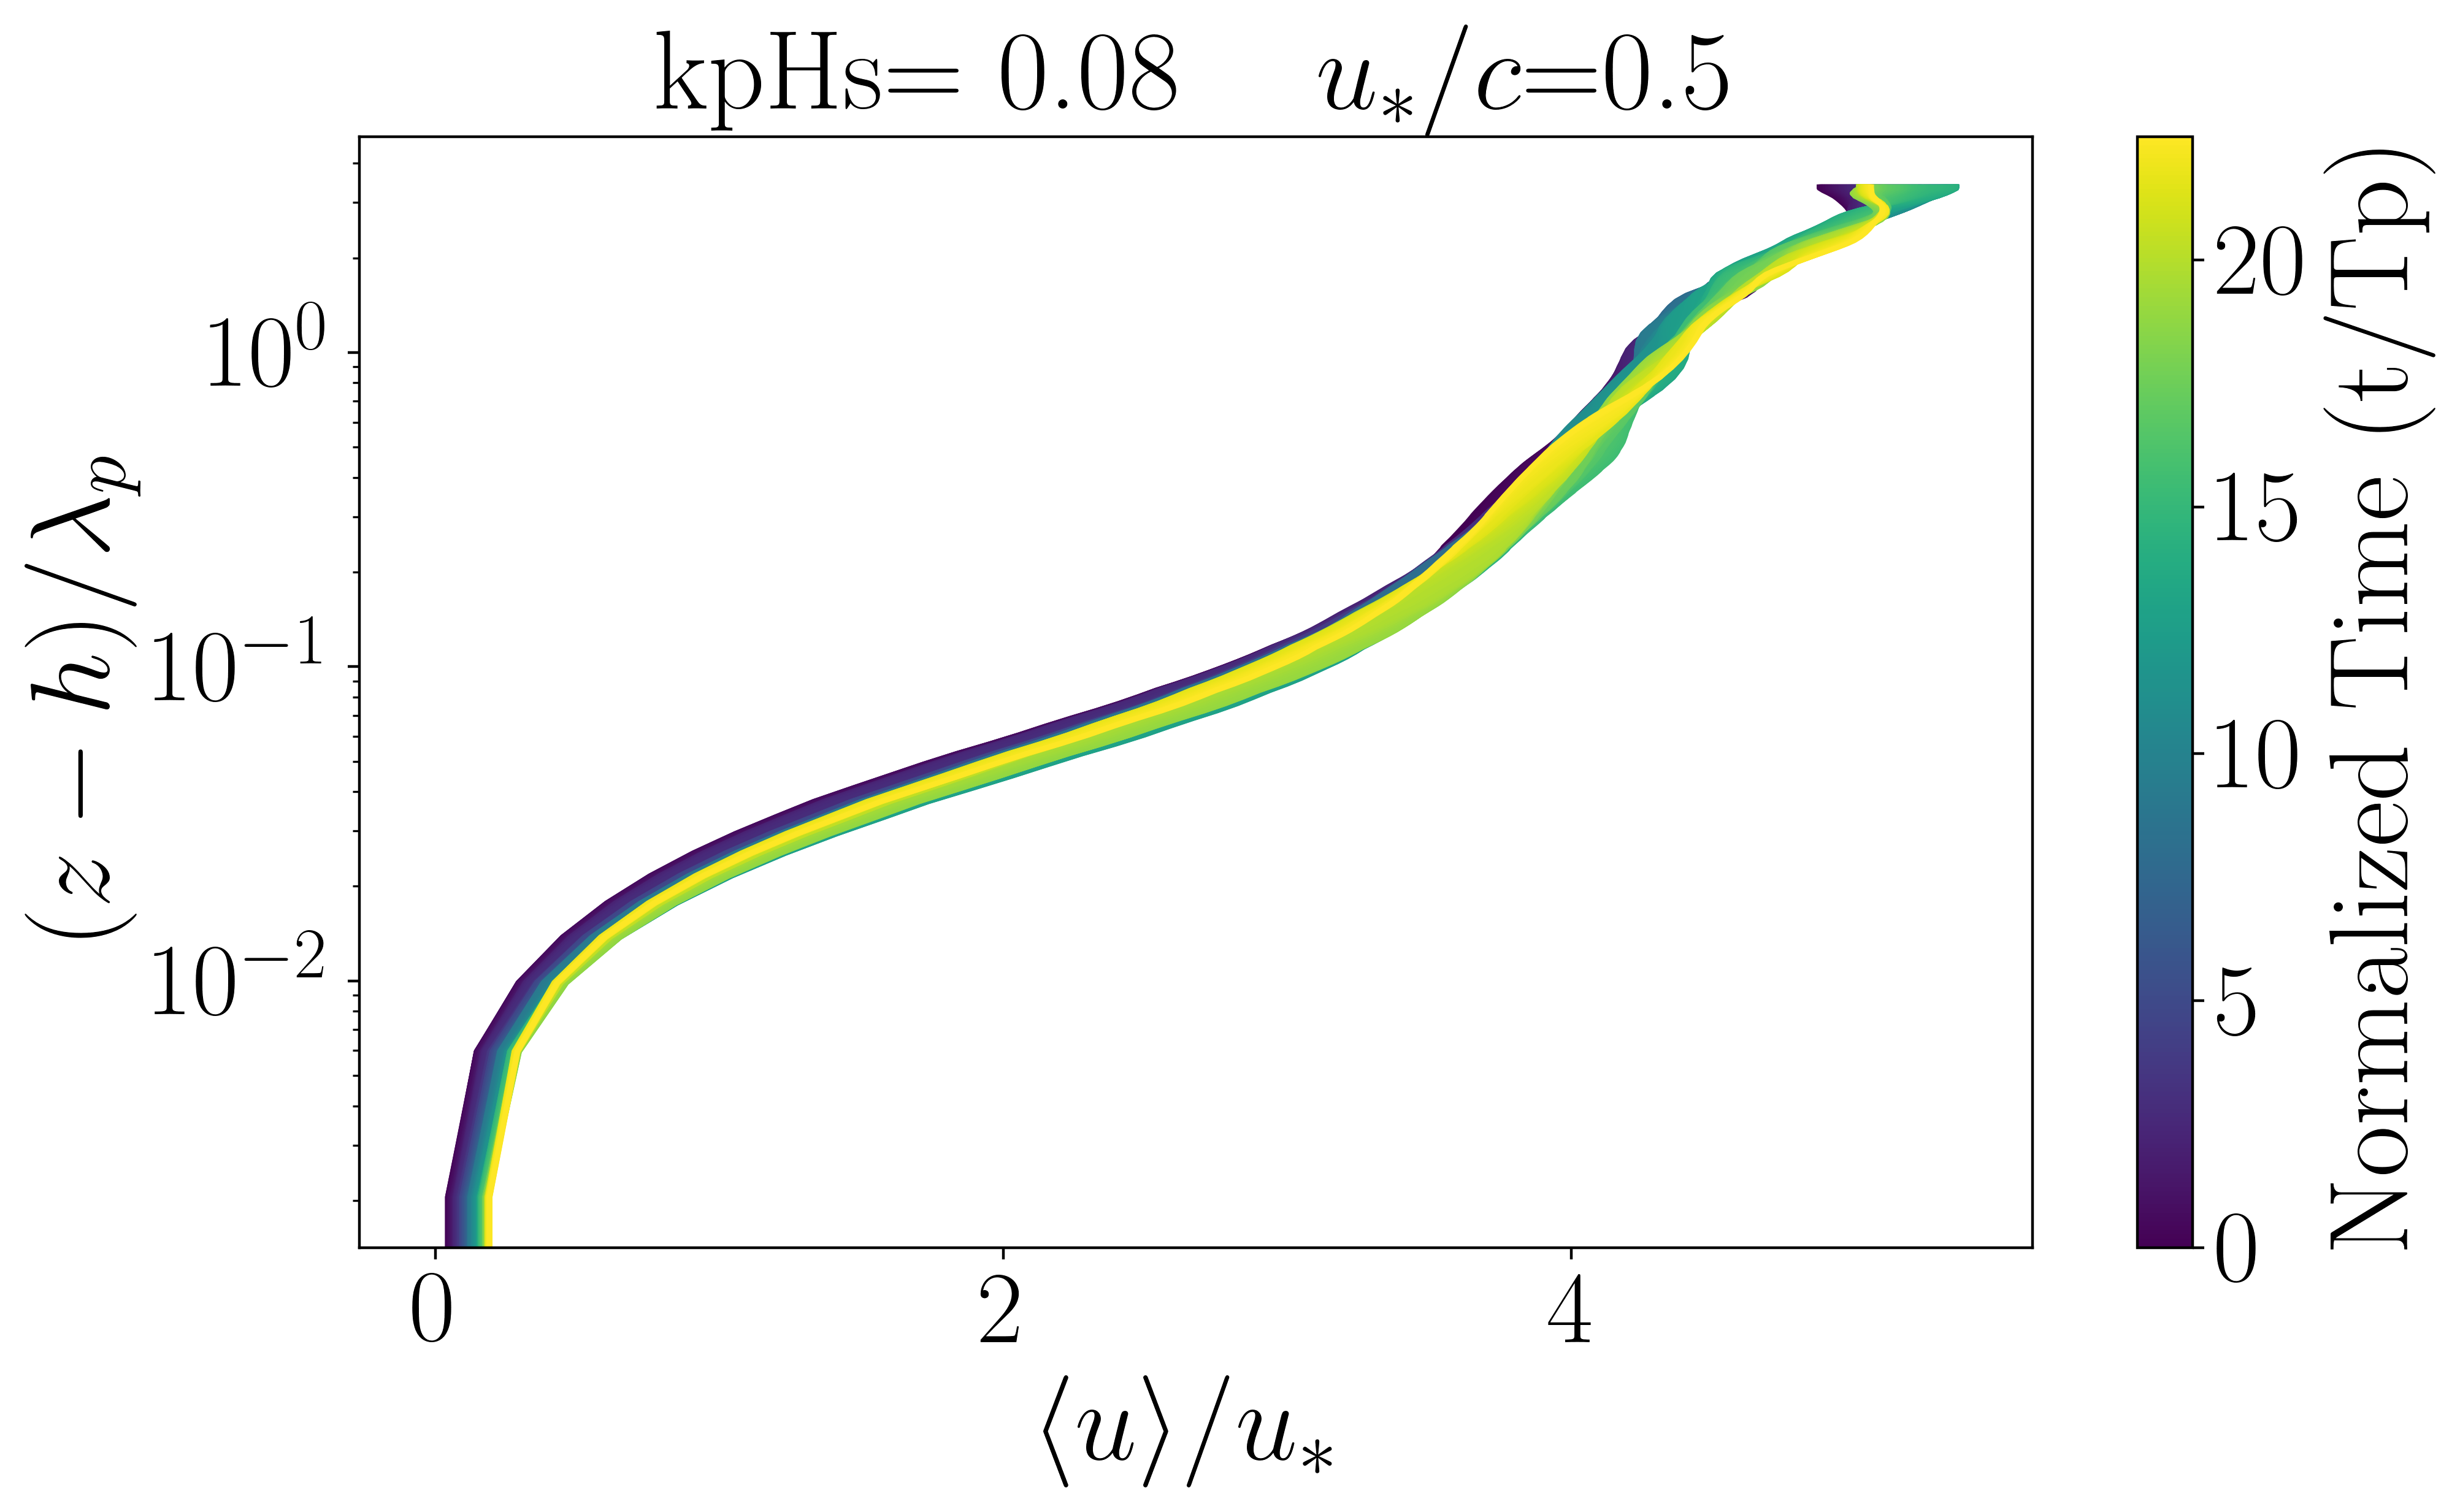

In [102]:
fig, ax = plt.subplots(figsize=[11, 6])
# Calcular valores de tiempo normalizados
time_normalized = (time - time[0]) * omegap / (2 * np.pi)

# Normalizar el rango de tiempo para la colorbar basado en los valores normalizados
norm = Normalize(vmin=np.min(time_normalized), vmax=np.max(time_normalized))

# Crear un ScalarMappable para generar colores a partir de la paleta de colores
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized)  # Se pasa el array de tiempo normalizado para evitar errores

# Asegurarse de que el bucle no exceda el tamaño de 'time_normalized'
for i in range(min(len(profiles_df), len(time_normalized))):
    phi_str = profiles_df.at[i, 'phi']
    u_z_str = profiles_df.at[i, 'u.x']
    phi_array = np.array(ast.literal_eval(phi_str))
    u_z_array = np.array(ast.literal_eval(u_z_str))

    color = sm.to_rgba(time_normalized[i])
    norm = lambdap
    # Graficar con el color correspondiente
    ax.plot( u_z_array ,(phi_array-1)/norm,  color=color) #/ (0.25**1) 


# Añade la barra de colores a la figura.
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time (t/Tp)')
#plt.axhline(y = 0.64, color = 'grey', linestyle = '--',lw=0.8) 

# Establecer escala logarítmica para el eje x
plt.yscale('log')
#plt.xlim([0.64,6]) #air
#plt.ylim([0.7,4])  #air
#plt.xlim([-0.001,0.1]) #water
#plt.ylim([-0.64,0.1]) #water
#plt.yscale('log')
plt.ylabel(r'$(z-h)/\lambda_{p}$')
plt.xlabel(r'$\langle u\rangle /u_\ast$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)

# Mostrar la gráfica
plt.show()

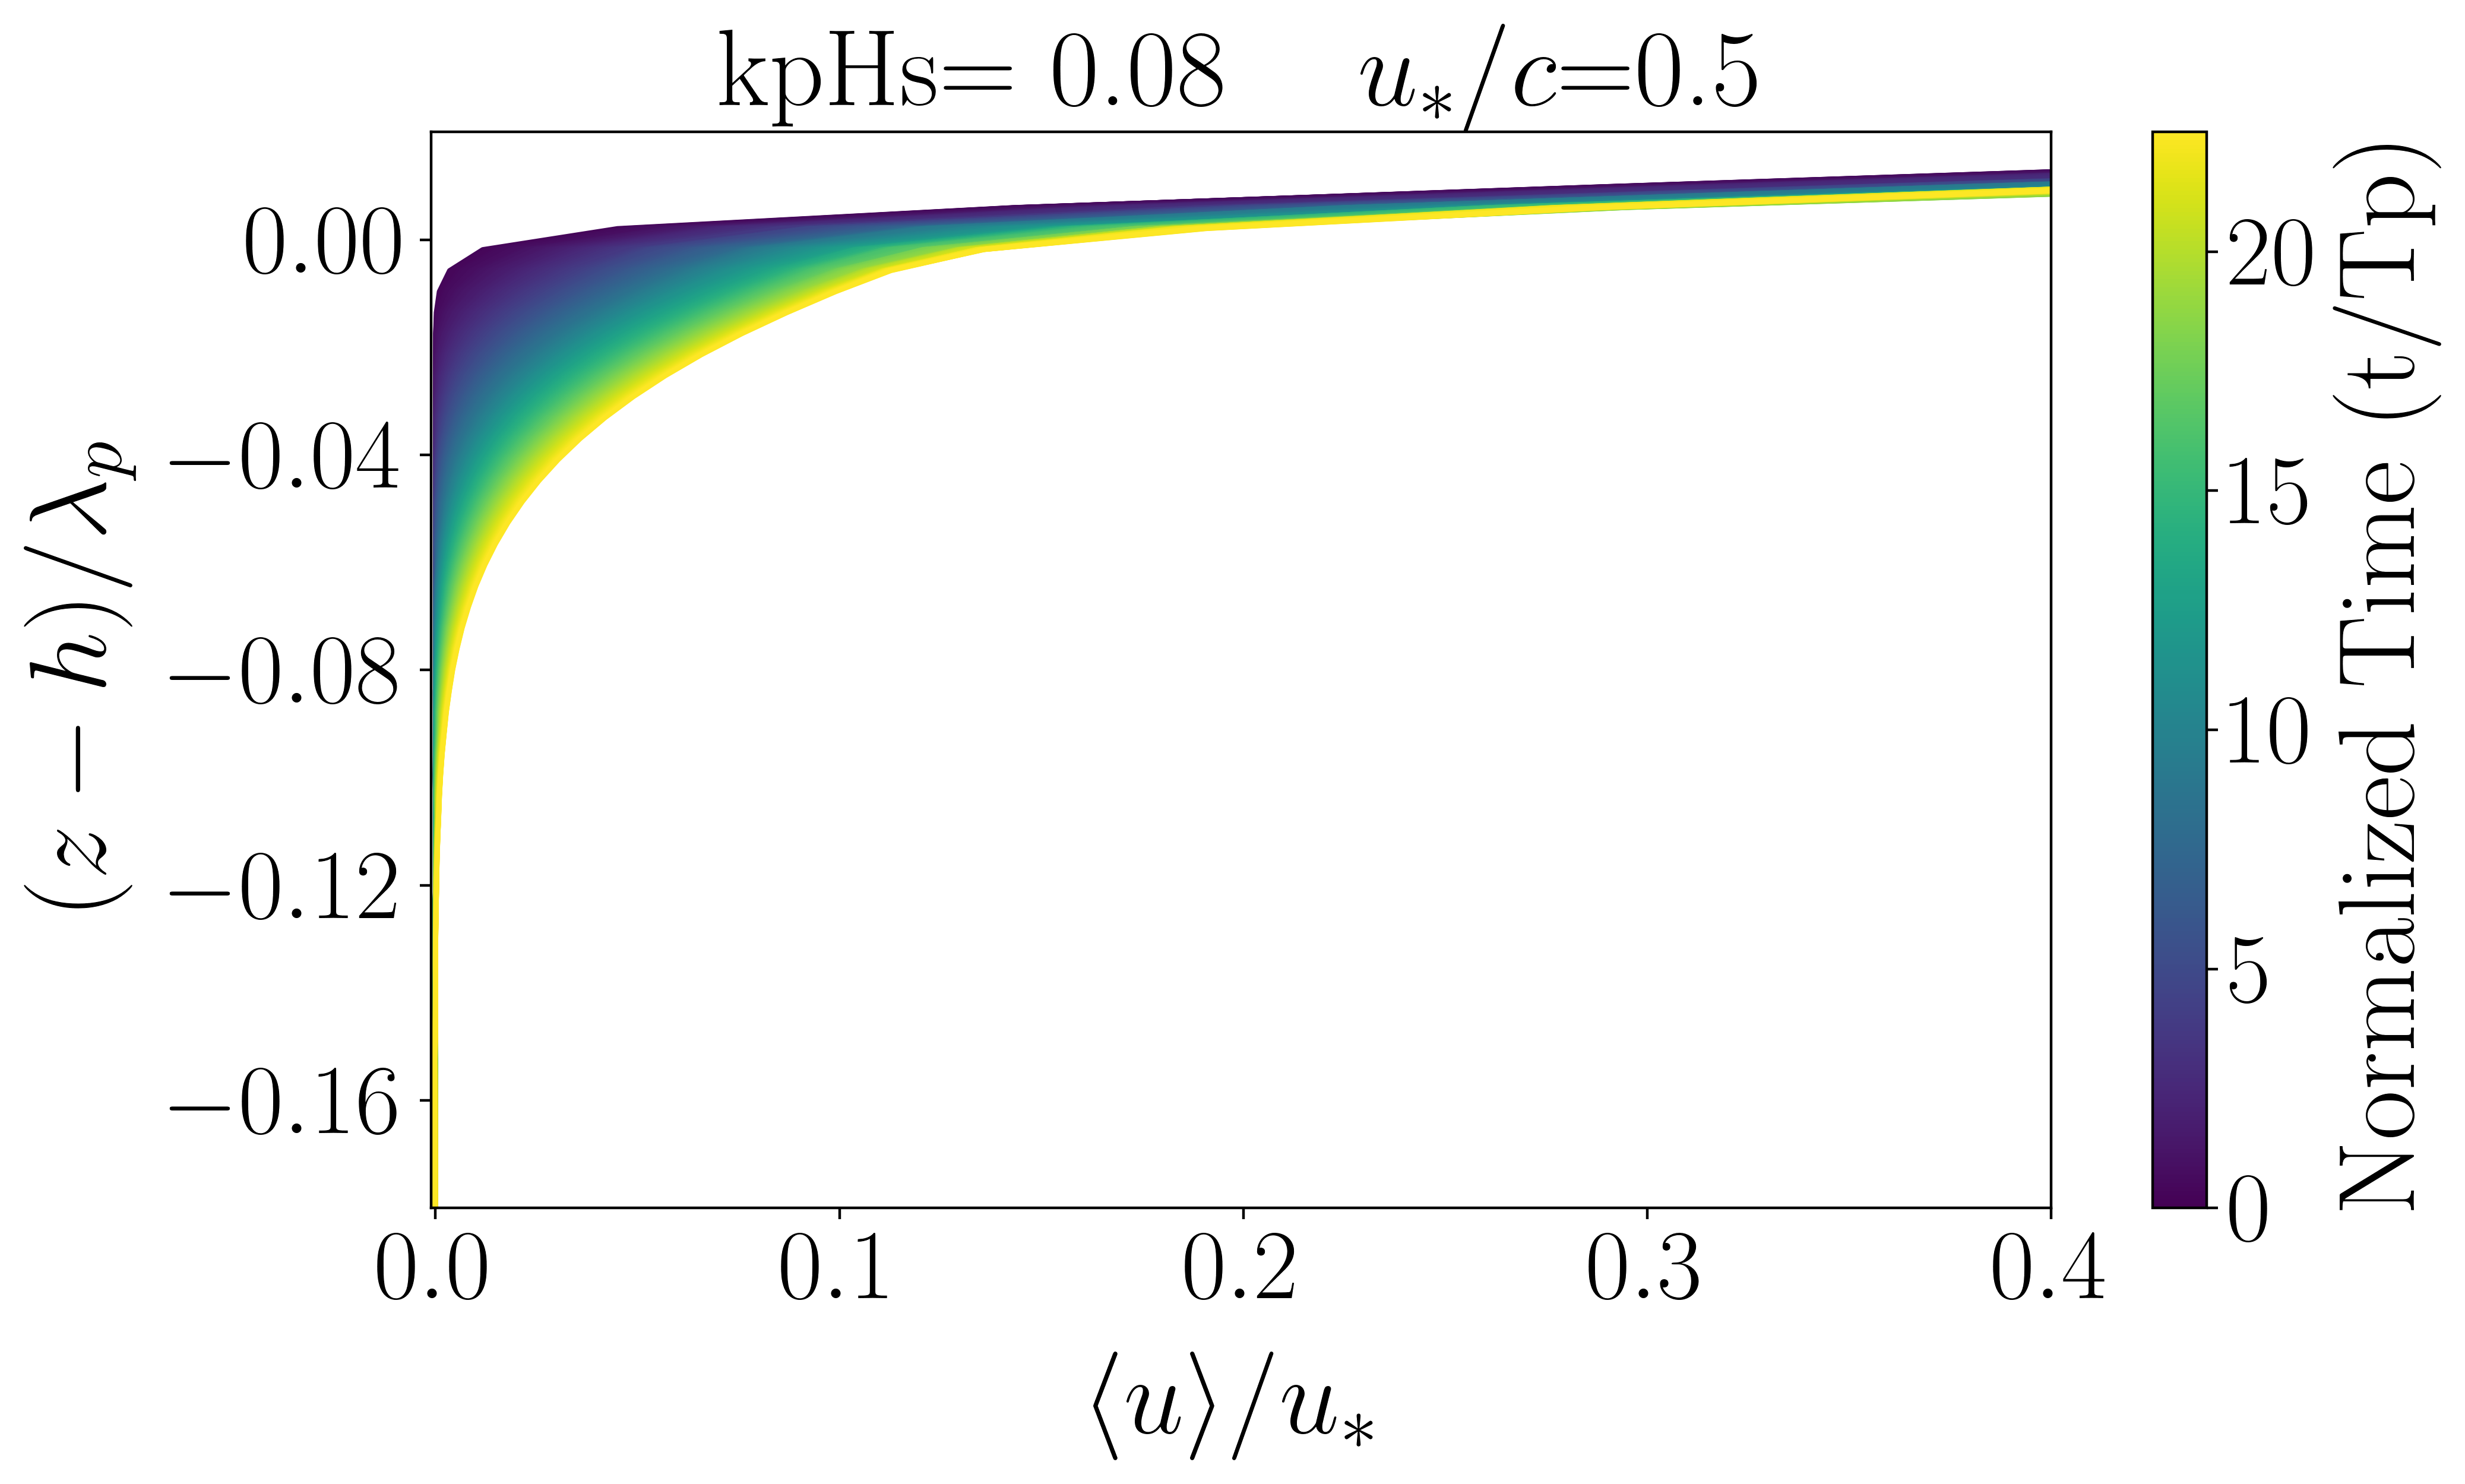

In [103]:
fig, ax = plt.subplots(figsize=[11, 6])

time_normalized = (time - time[0]) * omegap / (2 * np.pi)
norm = Normalize(vmin=np.min(time_normalized), vmax=np.max(time_normalized))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized) 

for i in range(5,len(time_normalized)):
    #print('i', i)
    phi_str = profiles_df.at[i, 'phi']
    u_z_str = profiles_df.at[i, 'u.x']
    phi_array = np.array(ast.literal_eval(phi_str))
    u_z_array = np.array(ast.literal_eval(u_z_str))

    color = sm.to_rgba(time_normalized[i])
    norm = np.sqrt(8*nu_water*(time[i]-time[0]))
    norm2 = lambdap
    # Graficar con el color correspondiente
    ax.plot( u_z_array ,(phi_array-1)/norm2,  color=color) #/ (0.25**1) 


# Añade la barra de colores a la figura.
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time (t/Tp)')
#plt.axhline(y = 0.64, color = 'grey', linestyle = '--',lw=0.8) 

# Establecer escala logarítmica para el eje x
#plt.yscale('log')
#plt.xlim([0.64,6]) #air
#plt.ylim([0.7,4])  #air
plt.xlim([-0.001,0.4]) #water
plt.ylim([-0.18,0.02]) #water
#plt.yscale('log')
# Configura las etiquetas y el título
plt.ylabel(r'$(z-h)/\lambda_{p}$', labelpad = 10)
plt.xlabel(r'$\langle u\rangle /u_\ast$', labelpad = 10)
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Mostrar la gráfica
plt.show()

### Velocity profile in each interval

In [42]:
tstart_vel = profiles_df['time'].iloc[0]
omegap = np.sqrt(1 * 4)

# Calcular los valores normalizados
time_normalized = (profiles_df['time'] - tstart_vel) * omegap / (2 * np.pi)

# Encontrar el índice del valor más cercano a 4.66
target = 4.66
idx_closest = np.argmin(np.abs(time_normalized - target))

# Definir la longitud del primer intervalo
interval_length = time_normalized.iloc[idx_closest]

# Crear una lista para almacenar los intervalos
intervals = []

# Inicializar el primer intervalo
start_idx = 0
end_idx = idx_closest
intervals.append((start_idx, end_idx))

# Crear los intervalos restantes con solapamiento de 0.5
overlap_fraction = 0.5
while end_idx < len(time_normalized) - 1:
    start_idx = int(end_idx - overlap_fraction * idx_closest)
    end_idx = start_idx + idx_closest
    if end_idx >= len(time_normalized):
        end_idx = len(time_normalized) - 1
    if time_normalized[end_idx] < (time_normalized[end_idx]-1):
        break
    intervals.append((start_idx, end_idx))

lambdap = 2 * np.pi / kp
norm2 = lambdap

# Crear subplots para cada intervalo
fig, axs = plt.subplots(nrows=len(intervals), figsize=(15, 8 * len(intervals)), sharex=True)

# Si solo hay un intervalo, axs no es una lista, así que lo convertimos en una lista
if len(intervals) == 1:
    axs = [axs]

# Colores para cada intervalo usando la paleta viridis
interval_colors = plt.cm.viridis(np.linspace(0, 1, len(intervals)))

# Crear un ScalarMappable para generar colores a partir de la paleta de colores
norm = Normalize(vmin=np.min(time_normalized), vmax=11.69)  # Ajustar el rango máximo a 11.69
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(time_normalized)

# Graficar los perfiles de velocidad en cada intervalo
for j, (start, end) in enumerate(intervals):
    ax = axs[j]
    for i in range(start, end + 1):
        phi_str = profiles_df.at[i, 'phi']
        u_z_str = profiles_df.at[i, 'u.x']
        phi_array = np.array(ast.literal_eval(phi_str))
        u_z_array = np.array(ast.literal_eval(u_z_str))

        color = sm.to_rgba(time_normalized[i])
        ax.plot(u_z_array, (phi_array - 1) / norm2, color=color)

    interval_label = f"{time_normalized.iloc[start]:.2f} - {time_normalized.iloc[end]:.2f}"
    ax.set_xlim([-0.001, 0.1])  # water
    ax.set_ylim([-0.18, 0.01])  # water
    ax.set_ylabel(r'$(z-h)/\lambda_p$', labelpad=10)
    ax.set_xlabel(r'$\langle u\rangle /u_\ast$', labelpad=10)  # /u_ast
    ax.set_title(f'Interval: [{interval_label}] $(t/Tp)$', pad=20)  # Aumenta el valor de pad para evitar la superposición

# Añadir la barra de colores a la figura.
#cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
#cbar.set_label('Normalized Time (t/Tp)')

plt.tight_layout()
plt.show()


0.0520939370508602
[array(0.05209394)]
0.07323327962882106
[array(0.05209394), array(0.07323328)]
0.08955687996596601
[array(0.05209394), array(0.07323328), array(0.08955688)]
0.10398464721186881
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465)]
0.11839654807252017
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465), array(0.11839655)]
0.13045552976901037
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465), array(0.11839655), array(0.13045553)]
0.1408963027381632
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465), array(0.11839655), array(0.13045553), array(0.1408963)]
0.150555791920939
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465), array(0.11839655), array(0.13045553), array(0.1408963), array(0.15055579)]
0.156120063303975
[array(0.05209394), array(0.07323328), array(0.08955688), array(0.10398465), array(0.11839655), array(0.13045553), array(0.1408963), arr

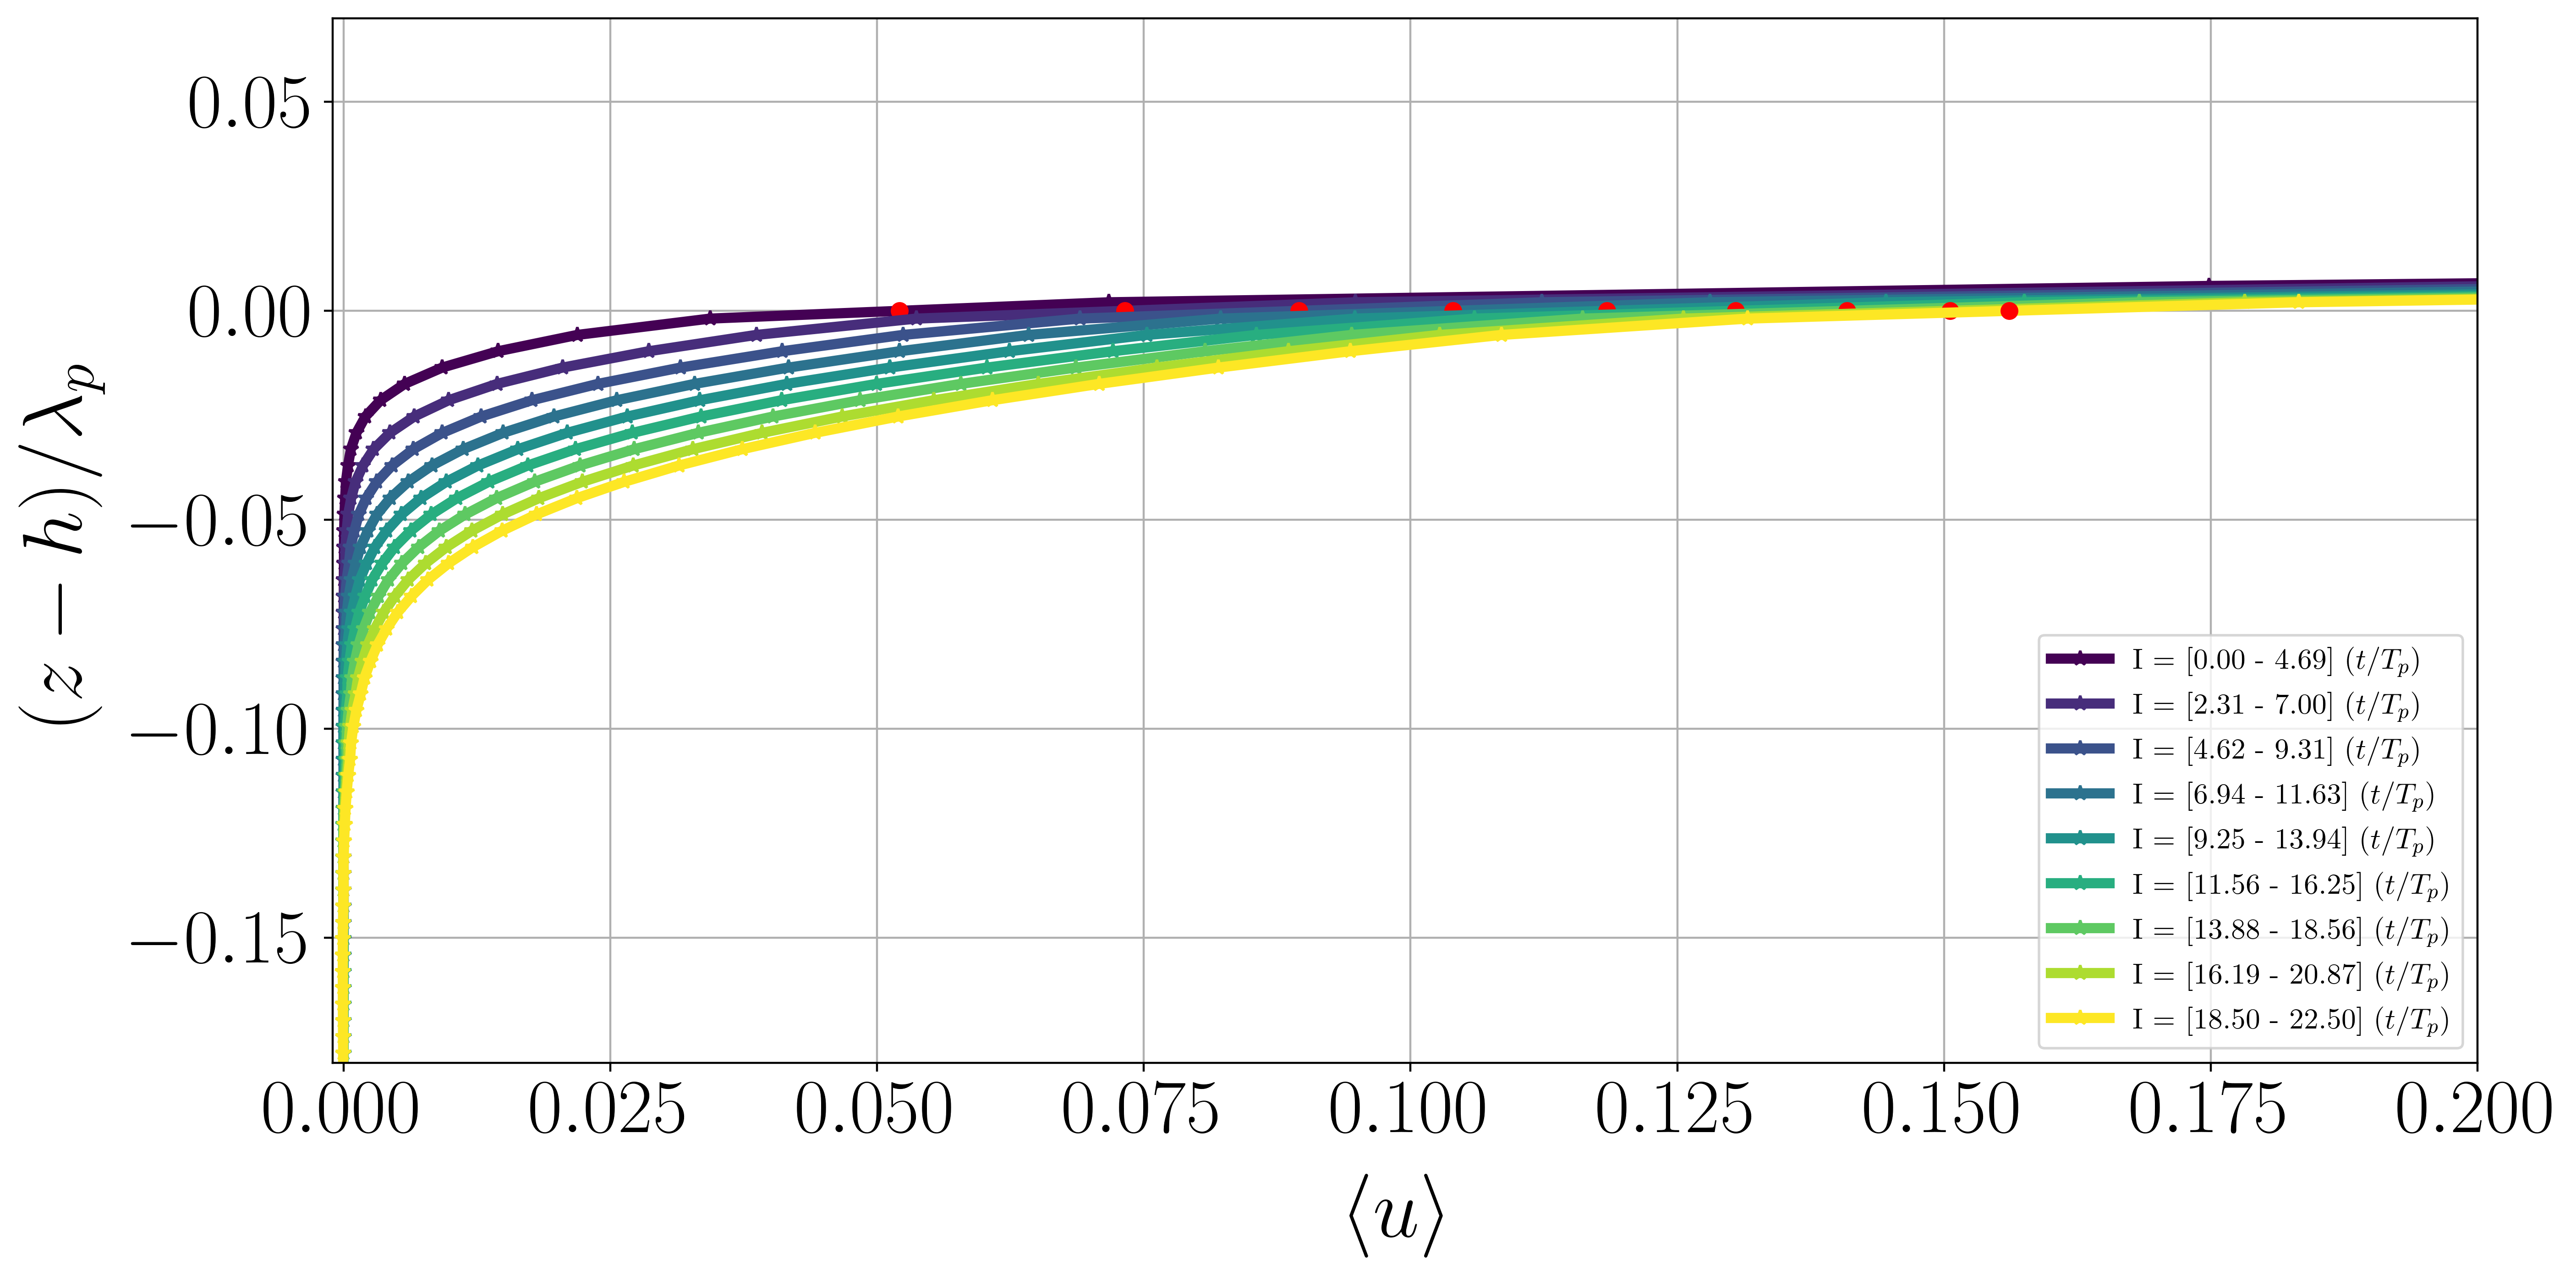

In [43]:
from scipy.interpolate import interp1d

tstart = profiles_df['time'].iloc[0]
omegap = np.sqrt(1 * 4)

# Calcular los valores normalizados
time_normalized = (profiles_df['time'] - tstart) * omegap / (2 * np.pi)

# Encontrar el índice del valor más cercano a 4.66
target = 4.66
idx_closest = np.argmin(np.abs(time_normalized - target))

# Definir la longitud del primer intervalo
interval_length = time_normalized.iloc[idx_closest]

# Crear una lista para almacenar los intervalos
intervals = []

# Inicializar el primer intervalo
start_idx = 0
end_idx = idx_closest
intervals.append((start_idx, end_idx))

# Crear los intervalos restantes con solapamiento de 0.5 y detenerse en 11.69
overlap_fraction = 0.5
while end_idx < len(time_normalized) - 1:
    start_idx = int(end_idx - overlap_fraction * idx_closest)
    end_idx = start_idx + idx_closest
    if end_idx >= len(time_normalized):
        end_idx = len(time_normalized) - 1
    if time_normalized[end_idx] < (time_normalized[end_idx]-1):
        break
    intervals.append((start_idx, end_idx))

phi_avg = []
u_x_avg = []

for start, end in intervals:
    accumulated_u_x = None
    count = 0

    for i in range(start, end + 1):
        phi_str = profiles_df.at[i, 'phi']
        u_x_str = profiles_df.at[i, 'u.x']
        phi_array = np.array(ast.literal_eval(phi_str))
        u_x_array = np.array(ast.literal_eval(u_x_str))

        if accumulated_u_x is None:
            accumulated_u_x = np.zeros_like(u_x_array)

        accumulated_u_x += u_x_array
        count += 1

    if count > 0:
        average_u_x = accumulated_u_x / count
    else:
        average_u_x = np.zeros_like(accumulated_u_x)

    phi_avg.append(phi_array)
    u_x_avg.append(average_u_x)

lambdap = 2 * np.pi / kp
norm2 = lambdap

interval_colors = plt.cm.viridis(np.linspace(0, 1, len(intervals)))

u_atzero=[]
plt.figure(figsize=(14, 7))
for i, (phi, u_x) in enumerate(zip(phi_avg, u_x_avg)):
    interval_label = f"{time_normalized.iloc[intervals[i][0]]:.2f} - {time_normalized.iloc[intervals[i][1]]:.2f}"
    phi_normalized = (phi - 1) / norm2
    plt.plot(u_x, phi_normalized, lw=4, label=f"I = [{interval_label}]  $(t/T_{{p}})$", color=interval_colors[i], marker='*')

    # Interpolación para encontrar u_x en z = 0
    if np.min(phi_normalized) <= 0 <= np.max(phi_normalized):  # Asegurarse de que 0 esté en el rango de phi_normalized
        interp_func = interp1d(phi_normalized, u_x, kind='linear', fill_value="extrapolate")
        u_at_z0 = interp_func(0)
        print(u_at_z0)
        u_atzero.append(u_at_z0)
        print(u_atzero)
        plt.plot(u_at_z0, 0, 'ro')  # Marcar los puntos interpolados en el gráfico
    
    
# Establecer los límites de los ejes
plt.xlim([-0.001, 0.2])  # water
plt.ylim([-0.18, 0.07])  # water

plt.ylabel(r'$(z-h)/\lambda_{p}$', labelpad=10)
plt.xlabel(r'$\langle u\rangle$', labelpad=10)  #  /u_\ast
#plt.title(r'$kpHs= 0.08 \quad  \quad u_\ast/c=0.5$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2.343750005777007
3.500000003958428
4.656250002139849
5.81250000032127
6.968749998502691
8.124999996684112
9.281249994865606


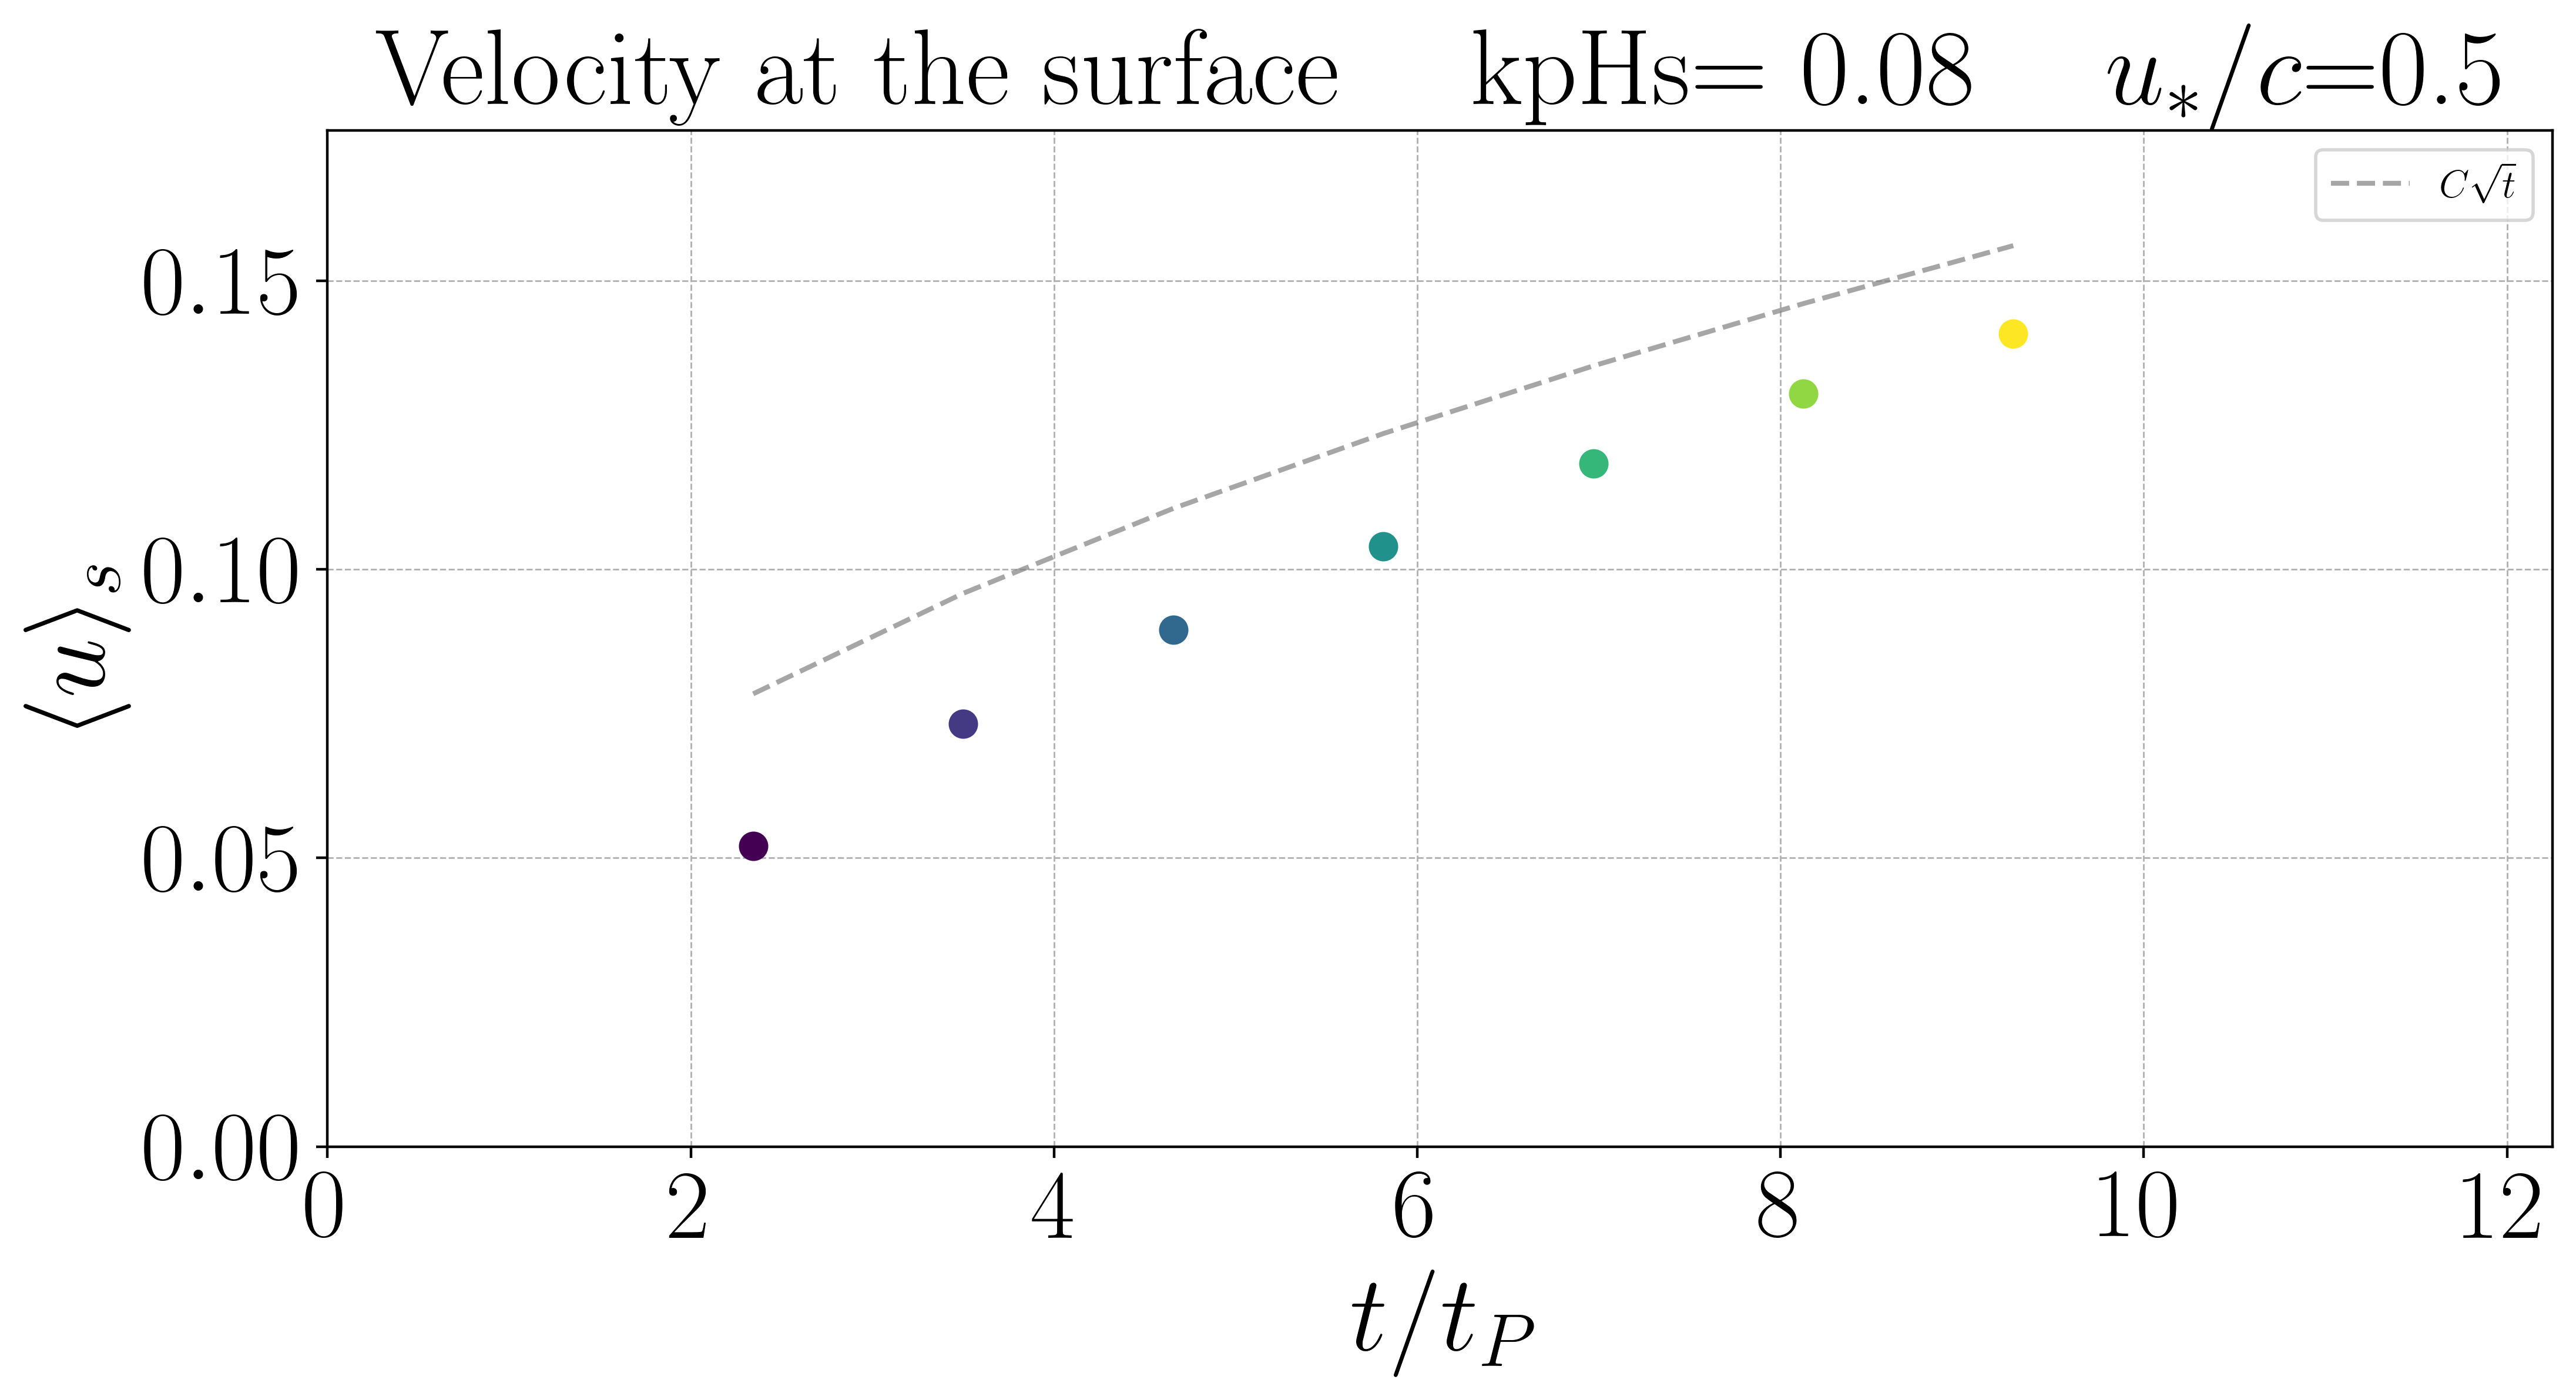

In [108]:
# Data for the second plot
times_moyen_08 = np.array([4.69/2, (2.31+7)/2, (4.62 + 9.31)/2, (6.94 + 11.63)/2, (9.37+14.03)/2, (11.72+16.37)/2, (14.06+18.72)/2])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(11, 6))

times_moyens =[]
# Plot the data
for i, color in enumerate(interval_colors):
    time_moyen = time_normalized[intervals[i][1]]/2
    print(time_normalized[intervals[i][1]]/2)
    ax.plot(time_moyen, u_atzero[i], marker='o', linestyle='-', color=color, markersize=8, linewidth=2)
    times_moyens.append(time_moyen)
    
    
# Normalize the sqrt function to better match the data range
sqrt_times_moyen = np.sqrt(np.array(times_moyens))
max_u_atzero = max(u_atzero)
normalized_sqrt_times = sqrt_times_moyen * (max_u_atzero / max(sqrt_times_moyen))
ax.plot(times_moyens, normalized_sqrt_times, ls='--', color='grey', alpha=0.7, label=r'$C \sqrt{t}$')

# Add title and labels
title_str = f'Velocity at the surface \quad kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
ax.set_xlabel(f'$t/t_{{P}}$')
ax.set_ylabel(r'$\langle u \rangle_{s}$')

# Add a grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
ax.legend(fontsize=12)

# Set axis limits
ax.set_xlim([0, max(time_moyens) + 1])
ax.set_ylim([0, max(u_atzero) + 0.02])

# Show the plot
plt.tight_layout()
plt.show()

# Mean velocity profile

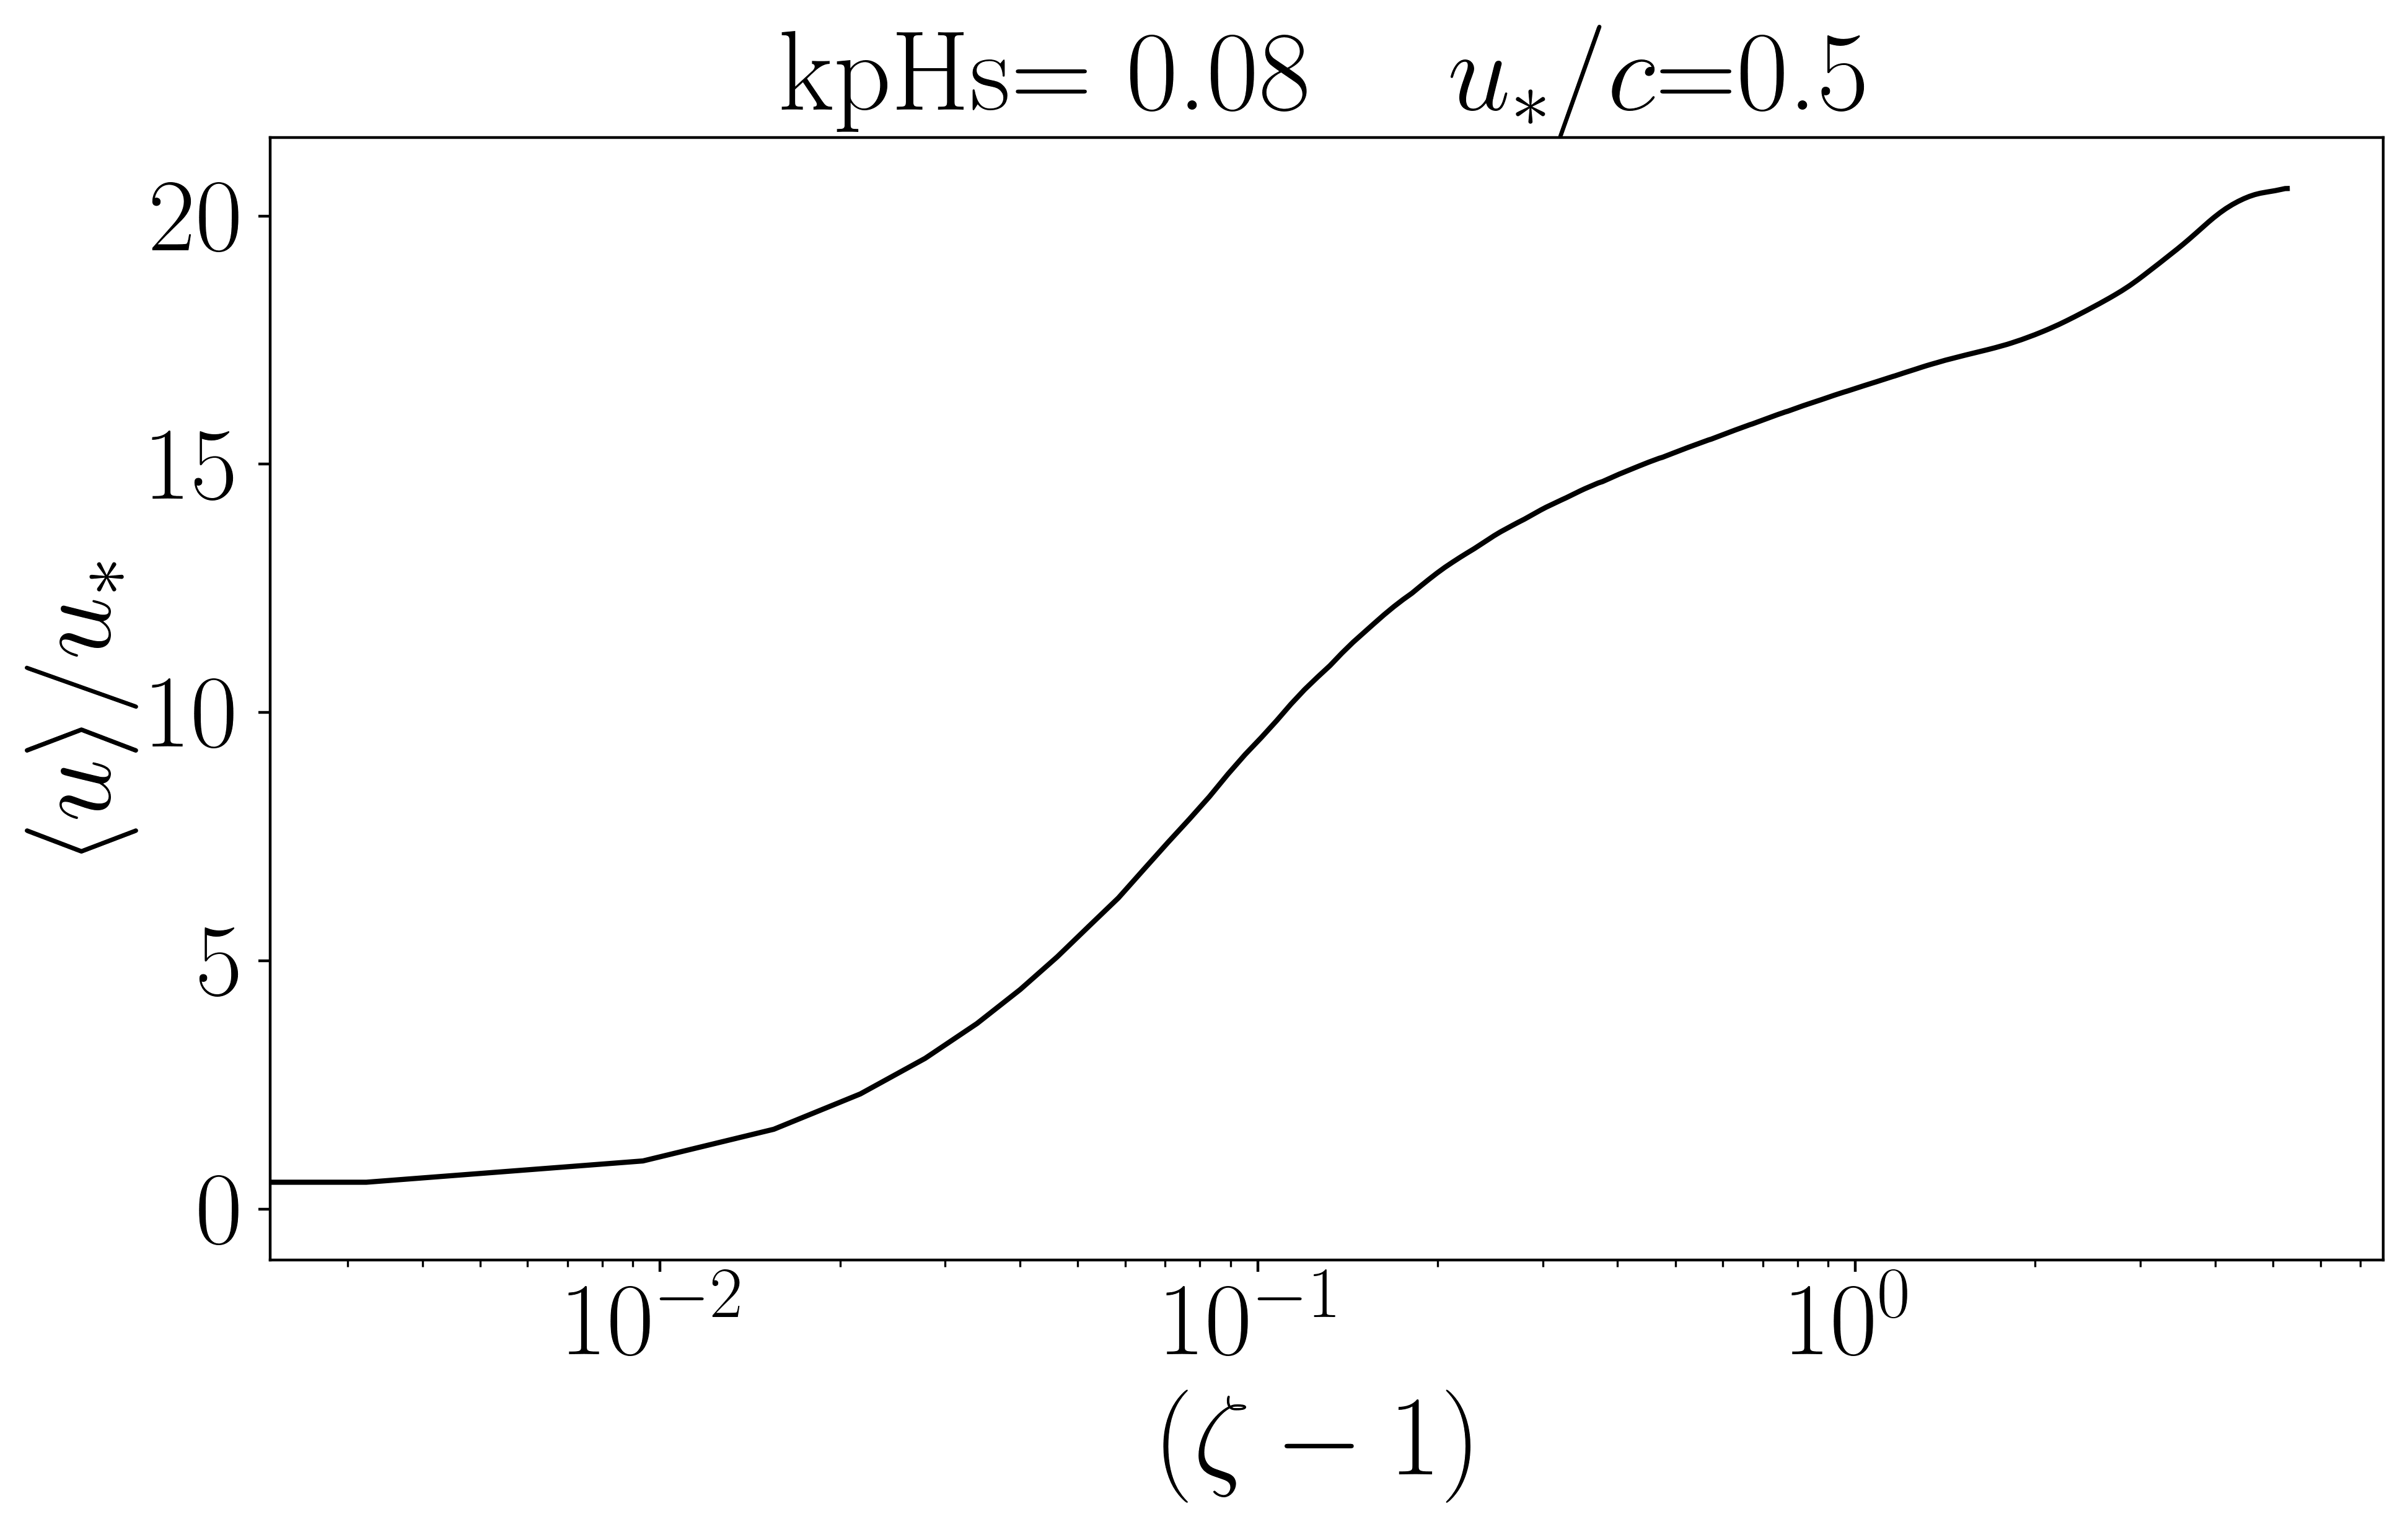

In [109]:
fig, ax = plt.subplots(figsize=[11, 6])
norm = Normalize(vmin=0, vmax=299)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

accumulated_u_z = np.zeros_like(np.array(ast.literal_eval(profiles_df.at[0, 'u.x'])))

for i in range(len(profiles_df)):
    u_z_str = profiles_df.at[i, 'u.x']
    u_z_array = np.array(ast.literal_eval(u_z_str))
    accumulated_u_z += u_z_array

average_u_z = accumulated_u_z / len(profiles_df)

ax.plot(phi_array-1, average_u_z/(0.25**1), color='black')  # color='black' para la línea promedio

plt.xscale('log')
plt.xlabel(r'$(\zeta - 1) $')
plt.ylabel(r'$\langle u\rangle /u_\ast$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)

#fig.save(fig_dir+"/
plt.show()

# Velocity fluctuations

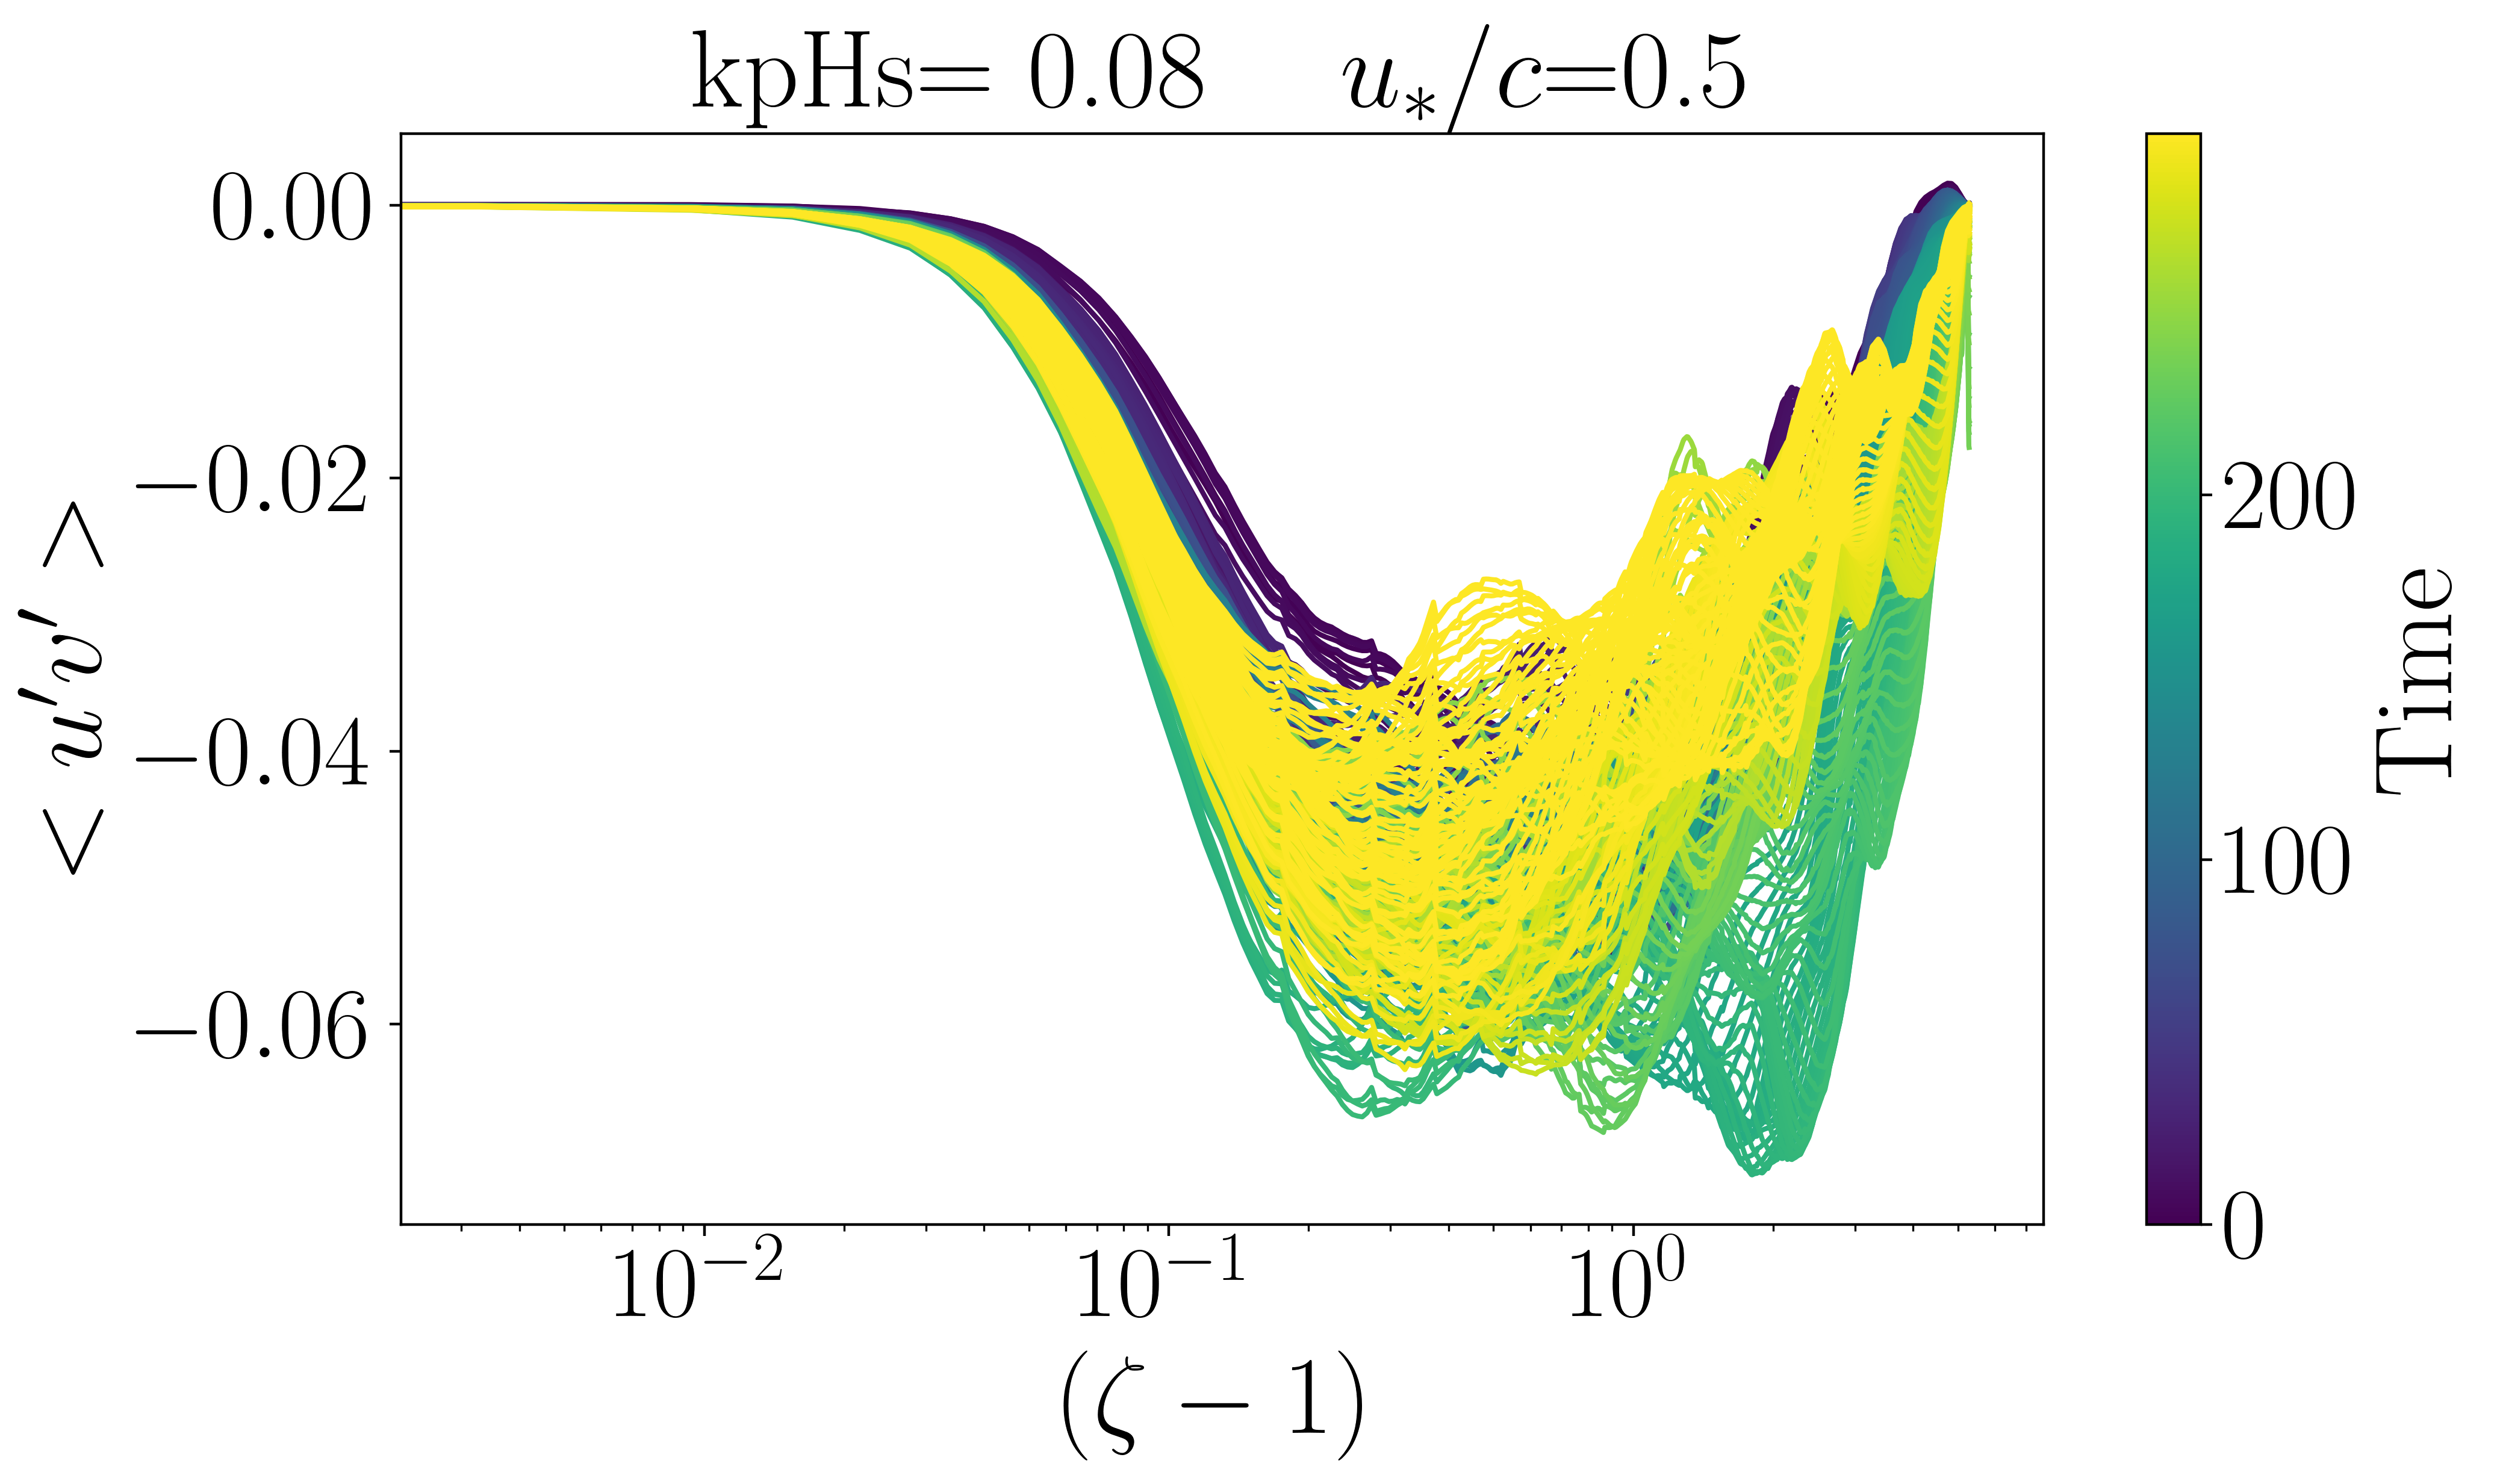

In [110]:
fig, ax = plt.subplots(figsize=[11, 6])

norm = Normalize(vmin=0, vmax=299)


sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([]) 

# 'phi', 'uv', 'u.x' y 'u.z' 
for i in range(len(profiles_df)):
    phi_array = np.array(ast.literal_eval(profiles_df.at[i, 'phi']))
    uv_array = np.array(ast.literal_eval(profiles_df.at[i, 'uv']))
    u_x_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.x']))
    u_z_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.y']))

    # Calcul fluctuations
    fluctuations_array = uv_array - u_x_array * u_z_array
    calc_array = (phi_array - 1) * 720
    # Color as time
    color = sm.to_rgba(i)
    ax.plot((phi_array - 1) , fluctuations_array, color=color)

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time')
ax.set_xscale('log')  
ax.set_xlabel(r'$(\zeta - 1)$')
ax.set_ylabel(r'$<u^\prime v^\prime>$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)
plt.show()

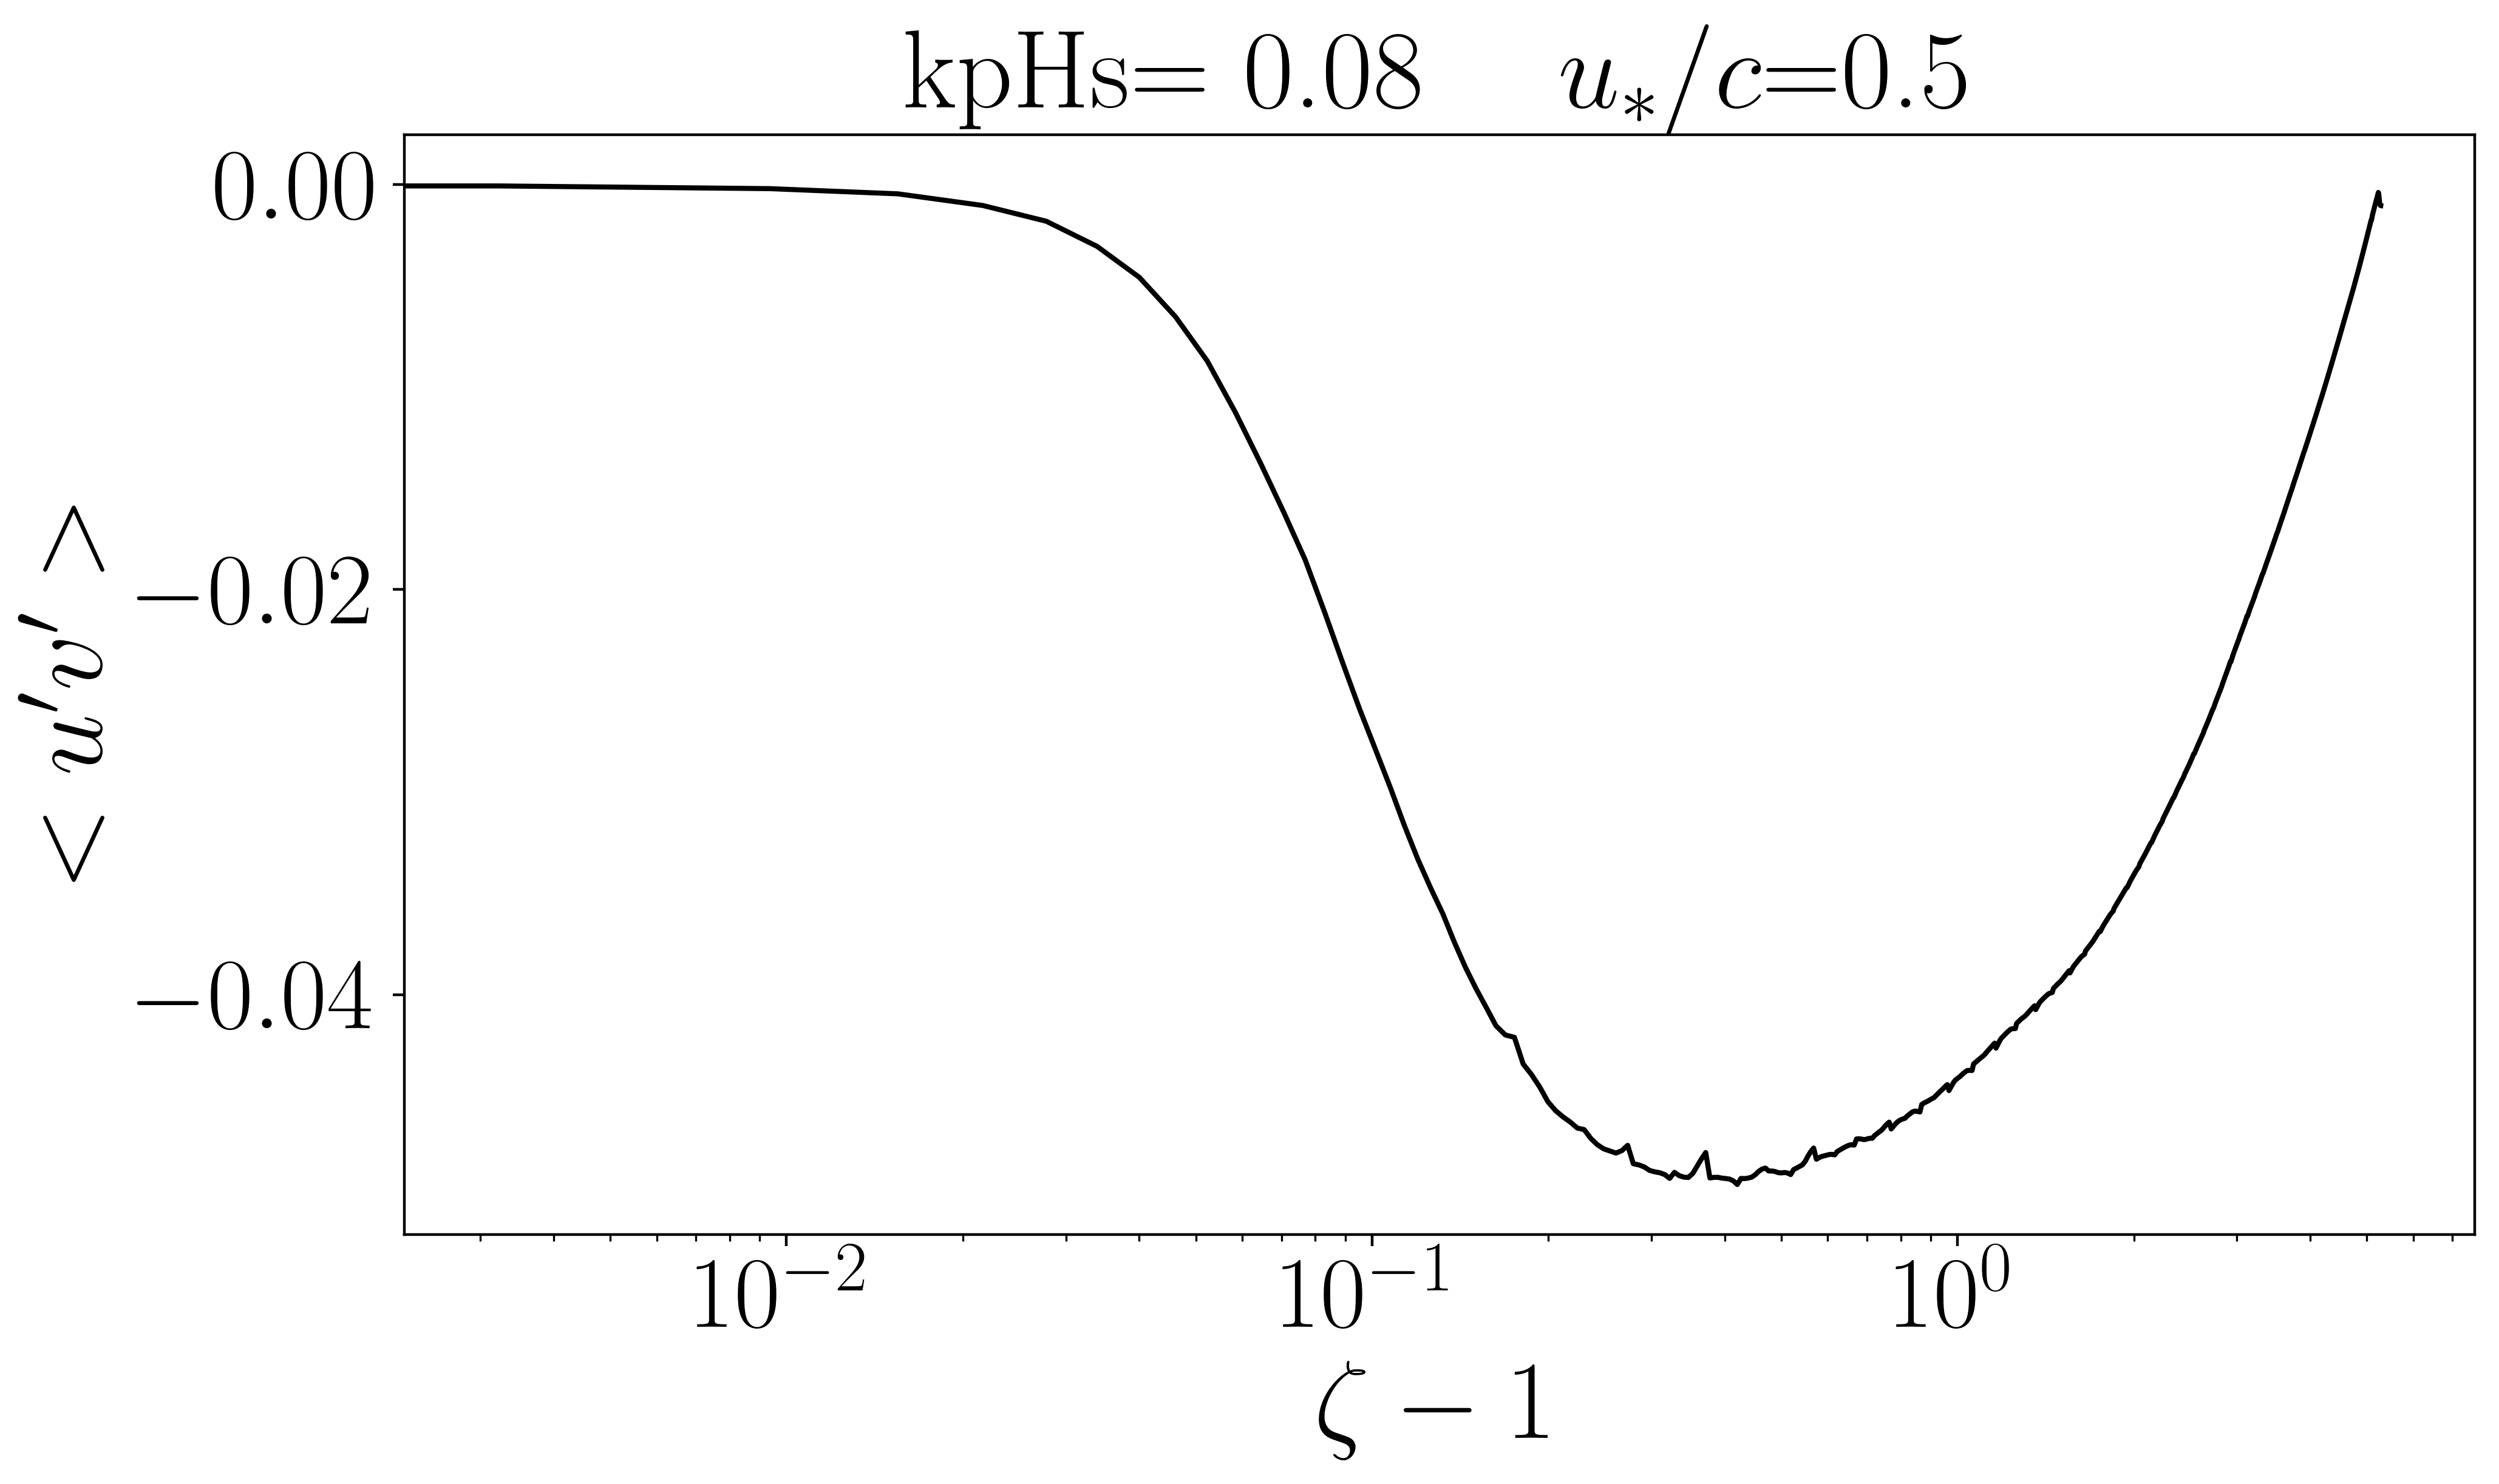

In [113]:
#MEAN FLUCTUATIONS

# Preparar la figura y los ejes
fig, ax = plt.subplots(figsize=[11, 6])

# Inicializar un arreglo para acumular las fluctuaciones
accumulated_fluctuations = None

# Calcular y acumular las fluctuaciones para cada tiempo
for i in range(len(profiles_df)):
    # Convertir de string a array numérico real
    phi_array = np.array(ast.literal_eval(profiles_df.at[i, 'phi']))
    uv_array = np.array(ast.literal_eval(profiles_df.at[i, 'uv']))
    u_x_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.x']))
    u_z_array = np.array(ast.literal_eval(profiles_df.at[i, 'u.y']))

    # Calcular fluctuaciones
    fluctuations_array = uv_array - u_x_array * u_z_array
    if accumulated_fluctuations is None:
        accumulated_fluctuations = np.zeros_like(fluctuations_array)
    accumulated_fluctuations += fluctuations_array

# Calcular el promedio de las fluctuaciones
average_fluctuations = accumulated_fluctuations / len(profiles_df)

# Calcular calc_array usando el primer 'phi_array' como representante, asumiendo que es constante
calc_array = (np.array(ast.literal_eval(profiles_df.at[0, 'phi'])) - 1) * 720

# Graficar el promedio de las fluctuaciones
ax.plot(phi_array-1, average_fluctuations, color='black', label='Average Fluctuations')

# Añadir la barra de colores

ax.set_xscale('log')
# Etiquetas y título
#ax.set_xlabel(r'$(\zeta - 1) 720$')
ax.set_xlabel(r'$\zeta -1 $')
ax.set_ylabel(r'$<u^\prime v^\prime>$')
title_str = f'kpHs= {ak} \quad  $ u_\\ast/c$={uoc_val}'
ax.set_title(title_str)

# Mostrar la gráfica
plt.show()